# Getting started with lionanalysis

## Introduction

``lionanalysis`` is a command-line program and not a Python library. It reads a text input file and produces text output files.

Here we use a Jupyter notebook just as a convenient way to look at the results of the analysis using ``ASE`` for atomic visualization, ``pandas`` for tabular data, and ``seaborn`` for producing plots.

However, ``lionanalysis`` was originally developed to be run from the command-line and using ``gnuplot`` to plot the files.


In [4]:
! pip install ase pandas seaborn



## Example trajectory: RuH.xyz

This example analyzes some frames from the trajectory ``RuH.xyz``.

This trajectory simulates hydrogen bombardment on a Ru surface. It contains 1001 frames with a variable number of hydrogen atoms, and a fixed number of Ru atoms.

Here are some snapshots:

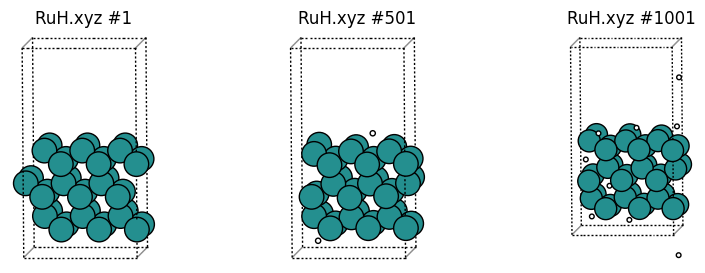

In [1]:
from common import plot_trajectory
plot_trajectory("trajectories/RuH.xyz");

This trajectory follows the ``mattixyz`` format, which specifies an orthorhombic lattice as ``XYZ a b c`` on the comment line:

In [2]:
%%bash
head -n 4 trajectories/RuH.xyz

36
XYZ 8.11452 8.54704 15.00000
Ru 1.35242 2.13676 7.46574
Ru 2.70484 0.00000 6.68492


``lionanalysis`` always assumes periodic boundary conditions, so if you have a non-periodic system, just set the lattice parameters to large values.

## Simple lionanalysis run to print number of Ru and H atoms as a function of time

A simple input might look like this. Comment lines start with ``#``.

In [3]:
%%sh

cat > ionanalysis1.config <<EOF
# trajectory file and format
DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz

# overwrite output files without asking
Overwrite

# run in serial (recommended for smallish systems)
# you can also set the environment variable OMP_NUM_THREADS=1
Threads 1

# print info to screen every 200 frames
CoutFrequency 200

# --- Group definitions --- #
DefineGroup H ATOMICNUMBER H
DefineGroup Ru ATOMICNUMBER Ru

# --- Print properties of groups --- #
PrintProperties properties.txt Every 1 GROUPS All H Ru PROPERTIES timestepiteration numatoms
AverageSize
EOF

lionanalysis.exe ionanalysis1.config

DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz
Overwrite
Threads 1
CoutFrequency 200
DefineGroup H ATOMICNUMBER H
DefineGroup Ru ATOMICNUMBER Ru
PrintProperties properties.txt Every 1 GROUPS All H Ru PROPERTIES timestepiteration numatoms
    ### AverageSize
FinalPrintProperties averagesize.dat MultipleLines PrintEvery 100 ALLGROUPS PROPERTIES groupname averagesize
###########################################################
Running on 1 threads on host .SCMCoffee1
There are 3 groups and 5 actions.
I am lionanalysis version 0.5
Opening dumpfile trajectories/RuH.xyz at byte 0 : 0
      -999       (1) (       0 ps) (6.79493e-05 s) (  0.0877 %)
      -800       (200) (     199 ps) (0.0095210075 s) (      19 %)
      -600       (400) (     399 ps) (0.019724131 s) (    39.1 %)
      -400       (600) (     599 ps) (0.02956295 s) (    58.7 %)
      -200       (800) (     799 ps) (0.03986311 s) (      79 %)
         0       (1000) (     999 ps) (0.050303936 s) (    99.9 %)
Closing dumpfil

### lionanalysis output

``lionanalysis`` will print out the input that it read and interpreted, and then print the progress as it reads through the trajectory. For .xyz file the "timestep number" starts at ``-999`` for historical reasons. For other file formats, like output from LAMMPS, the timestep number is part of the file format and then that number is used instead. 

lionanalysis also prints the "timestep iteration", which starts at 1.

### DefineGroup ATOMICNUMBER

The line ``DefineGroup Ru ATOMICNUMBER Ru`` means to define a group called ``Ru`` containing the atoms for which the first column (atomic number, chemical element) in the .xyz file is equal to ``Ru``. We can then refer to that group of atoms with later commands.

A group name cannot contain whitespace. It is also advisable to NOT name a group ``VARIABLE``, ``COMMAND``, ``SPECIAL``, ``All``, ``ALLGROUPS``, etc., since these are special words used to interpret the input. See the documentation for details.

Group names are case insensitive, so ``Ru`` and ``ru`` refer to the same group. In the output files, groups are typically written in lowercase.

### Group All



There is a special group called ``All`` that contains all atoms. It is the only group that you cannot (and should not) define yourself in the input.

### AverageSize

**AverageSize is the single most useful analysis command in lionanalysis**. It will produce an output file called ``averagesize.dat`` which prints the average number of atoms in each group. This allows you to quickly sanity-check that your group definitions are correct:

In [4]:
%%sh
cat averagesize.dat

# mCount = 1001 DESCR FinalPrintProperties averagesize.dat MultipleLines PrintEvery 100 ALLGROUPS PROPERTIES groupname averagesize
#all h ru 
### FRAME  ###


all 41.1728 
h 5.17283 
ru 36 


``AverageSize`` is just a shorthand alias for a particular ``FinalPrintProperties`` command. The details will be explained later.

### PrintProperties

The ``PrintProperties`` command creates an output file called ``properties.txt`` that contains the number of atoms (``numatoms``) as a function of frame number (``timestepiteration``).

Let's look a the first few rows:

In [5]:
%%sh
head -n 4 properties.txt | column -t

#iter  all  h  ru
1      36   0  36
2      37   1  36
3      37   1  36


This means that in the first frame, there are 36 atoms (0 ``H`` and 36 ``Ru``)

In the second frame, there are 37 atoms (1 ``H`` and 36 ``Ru``), etc.

## Load and plot data with pandas, matplotlib, seaborn

Let's instead load this into a pandas dataframe which will make it easier to manipulate and plot the data. Note that the column names in ``properties.txt`` are in lowercase.

In [6]:
import pandas as pd
df = pd.read_csv("properties.txt", sep="\s+")
df.head()

,#iter,all,h,ru
0,1,36,0,36
1,2,37,1,36
2,3,37,1,36
3,4,37,1,36
4,5,37,1,36


Let's plot:

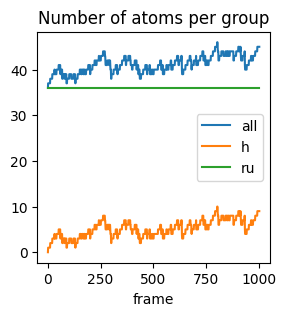

In [7]:
df.plot(
    x="#iter", 
    y=df.columns.drop("#iter"), 
    kind="line", 
    xlabel="frame", 
    title="Number of atoms per group", 
    figsize=(3, 3)
);

## Defining groups and finding out atomic environments

Above we defined the groups H and Ru using the ``ATOMICNUMBER`` option to ``DefineGroup``. These are trivial groups to define, but the real power of ``lionanalysis`` lies in the ability to define groups based on (time-dependent) atomic environments.

It is typically useful to distinguish atoms based on coordination number (for example, covalent bonds or hydrogen bonds).

Before you can reasonably define groups, you need to know a bit more about the system, for example typical bond lengths, coordination numbers, cartesian coordinates, etc.

So let's try to 

* plot some radial distribution functions, and
* get histograms of coordination numbers

before we try to define some advanced groups on which we can extract example configurations and calculate statistical properties.



### Radial distribution function

In [8]:
%%sh
cat > ionanalysis2.config <<EOF
CoutFrequency 100
DefineGroup H ATOMICNUMBER H
DefineGroup Ru ATOMICNUMBER Ru
RDF H H rdf_h_h.txt MaxDist 6.0 Resolution 0.05
RDF Ru H rdf_ru_h.txt MaxDist 6.0 Resolution 0.05
RDF Ru Ru rdf_ru_ru.txt MaxDist 6.0 Resolution 0.05
EOF

OMP_NUM_THREADS=1 lionanalysis.exe ionanalysis2.config --overwrite --dumpfile trajectories/RuH.xyz --format mattixyz > lionanalysis_output.txt

The Overwrite, DumpFile, and DumpFileFormat input options can also be specified on the command-line as shown above. It is convenient to do so, so that you can reuse the same ``ionanalysis.config`` input file for multiple different trajectories.

Let's inspect an rdf output file:

In [9]:
%%bash
head -n 10 rdf_ru_ru.txt

#r RDF iRDF PMF(kTunits) rawcount rawcountpertimestepperatom # from ru to ru; nSteps = 1001 size(ru) = 36 size(ru) = 35 numberdens. = 0.0336433
0.025 0 0 inf 0 0
0.075 0 0 inf 0 0
0.125 0 0 inf 0 0


0.175 0 0 inf 0 0
0.225 0 0 inf 0 0
0.275 0 0 inf 0 0
0.325 0 0 inf 0 0
0.375 0 0 inf 0 0
0.425 0 0 inf 0 0


The distance is in the first column and the RDF in the second column. This file is meant to be plotted in gnuplot using for example ``plot 'rdf_ru_ru.txt' u 1:2 w l ti "Ru-Ru rdf"``. However, we can also plot like this:

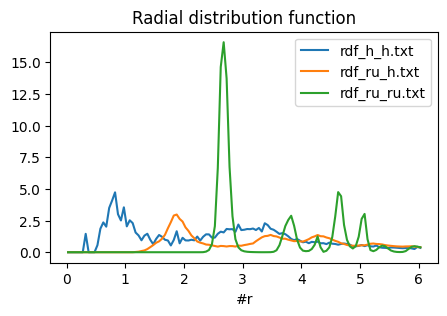

In [10]:
import matplotlib.pyplot as plt

def rdf2df(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, sep="\s+").iloc[:, :6]

rdf_files = ["rdf_h_h.txt", "rdf_ru_h.txt", "rdf_ru_ru.txt"]

fig, ax = plt.subplots()
for f in rdf_files:
    rdf2df(f).plot(x="#r", y="RDF", ax=ax, title="Radial distribution function", figsize=(5, 3))
ax.legend(rdf_files);

Note that RDFs are really only scientifically meaningful in spherical environments (liquids, crystals), not the kind of surface slab that is present in this trajectory. You could use the ``rawcount`` or ``rawcountpertimestepperatom`` columns instead to not normalize by the density.



However, from the above graph we can see that a typical Ru-H bond seems to be about 1.9 angstrom, and a typical Ru-Ru bond is about 2.8 angstrom. In this example the H-H rdf does not tell us much about the H-H bond length since the hydrogens mostly exist as isolated atoms and not as H2 molecules in this trajectory. The small peak at ~0.3 angstrom arises because the hydrogen atoms are accelerated towards the surface slab at very high speed.

### Groups based on distances and histograms of coordination numbers

From the above analysis, we define two Ru atoms to be bonded if the distance is smaller than 3.1 angstrom, and Ru-H to be bonded if the distance is smaller than 2.5 angstrom. We can do this by defining a ``BOND`` group with minimum and maximum distances and coordination numbers.

By setting ``MinCoord 0`` all Ru atoms with coordination numbers greater than or equal to ``0`` will be part of the new group. This is, in fact, all Ru atoms! Here we include ``0`` just in case there is a non-coordinated Ru atom. If all Ru atoms are in the group, then we can extract the coordination numbers later.

In [11]:
%%bash
cat > ionanalysis3.config <<EOF
DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 100

# ATOMICNUMBER groups
DefineGroup H ATOMICNUMBER H
DefineGroup Ru ATOMICNUMBER Ru

# BOND groups are defined as:
# DefineGroup groupname BOND fromgroup togroup ......
# NOTE that by setting MinCoord 0 all atoms in the group ``fromgroup`` will become part of the group ``groupname``.
# So H_H(AllCN) will include all hydrogen atoms, even the ones that are not bonded to any other hydrogens.
DefineGroup Ru_Ru(AllCN) BOND Ru Ru MinDist 0.0 MaxDist 3.1 MinCoord 0 
DefineGroup Ru_H(AllCN) BOND Ru H MinDist 0.0 MaxDist 2.5 MinCoord 0
DefineGroup H_Ru(AllCN) BOND H Ru MinDist 0.0 MaxDist 2.5 MinCoord 0
DefineGroup H_H(AllCN) BOND H H MinDist 0.0 MaxDist 0.85 MinCoord 0

# Histograms
Histogram hist_ru_ru_cn.txt DynamicRange GROUPS Ru_Ru(AllCN) PROPERTIES coordinationnumber
Histogram hist_ru_h_cn.txt DynamicRange GROUPS Ru_H(AllCN) PROPERTIES coordinationnumber
Histogram hist_h_ru_cn.txt DynamicRange GROUPS H_Ru(AllCN) PROPERTIES coordinationnumber
Histogram hist_h_h_cn.txt DynamicRange GROUPS H_H(AllCN) PROPERTIES coordinationnumber

AverageSize
EOF

OMP_NUM_THREADS=1 lionanalysis.exe ionanalysis3.config > lionanalysis_output.txt

In [12]:
%%sh
cat averagesize.dat

# mCount = 1001 DESCR FinalPrintProperties averagesize.dat MultipleLines PrintEvery 100 ALLGROUPS PROPERTIES groupname averagesize
#all h ru ru_ru(allcn) ru_h(allcn) h_ru(allcn) h_h(allcn) 
### FRAME  ###
all 41.1728 
h 5.17283 
ru 36 
ru_ru(allcn) 36 
ru_h(allcn) 36 
h_ru(allcn) 5.17283 
h_h(allcn) 5.17283 


Here we see that for example ``ru_h(allcn)`` contains the same number of atoms as the ``ru`` group (i.e., all Ru atoms), as expected from the ``MinCoord 0`` definition.

We can then look at a histogram of coordination numbers, for example the number of Ru atoms that Ru atoms coordinate (``hist_ru_ru_cn.txt``):

In [13]:
%%sh
cat hist_ru_ru_cn.txt

#value #count #fractional #divbycount Histogram hist_ru_ru_cn.txt DynamicRange GROUPS Ru_Ru(AllCN) PROPERTIES coordinationnumber# mCount = 1001 # sum = 36036 # sumcount = 36036 # wavg = 9.99395
0 0 0 -nan
1 0 0 -nan
2 0 0 -nan
3 0 0 -nan
4 2 5.55001e-05 1
5 1 2.775e-05 1
6 11 0.00030525 1
7 52 0.001443 1
8 11953 0.331696 1


9 68 0.001887 1
10 11937 0.331252 1
11 51 0.00141525 1
12 11961 0.331918 1


To plot all histograms side by side, it is easiest to use seaborn:

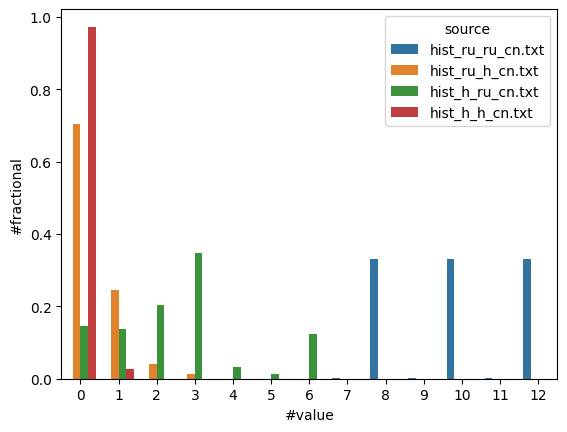

In [14]:
import seaborn as sns

def hist2df(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, sep="\s+").iloc[:, :4]

hist_files = ["hist_ru_ru_cn.txt", "hist_ru_h_cn.txt", "hist_h_ru_cn.txt", "hist_h_h_cn.txt"]

df = pd.concat(hist2df(f).assign(source=f) for f in hist_files)
sns.barplot(df, x="#value", y="#fractional", hue="source");

Here we see that

* Ru-Ru: The most common coordination number for Ru-Ru is 8, 10, or 12
* Ru-H: Most Ru atoms coordinate 0 H atoms
* H-Ru: H may coordinate 0-6 Ru atoms
* H-H: 95+% of H atoms do not coordinate any other H atoms

Let's check our work and try to visualize some of these atomic environments.

## Visualize atoms in different groups

When defining groups, it is important to **always verify that the group contains ONLY the kinds of atoms you expect**. In molecular dynamics, it is often difficult to foresee all the chemical environments around atoms, and the group definitions can become arbitrarily complex.

To see which atoms are part of a group, it is easiest to use the ``PrintGroup`` command. It has a special option ``Special`` which lets you print atoms that are in a particular group as a different chemical element. This makes it easy to visualize and is the approach we use below.

You can also add a condition ``IfGroupNotEmpty <group_name>``. For example ``PrintGroup All XYZ filename.xyz IfGroupNotEmpty H2`` means that all atoms will be printed to filename.xyz, but only those frames when the group ``H2`` contains at least one atom.

The ``SUBGROUPCN`` kind of group can be used to filter on coordination numbers.

In [15]:
%%bash
cat > ionanalysis4.config <<EOF
DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 100

DefineGroup H ATOMICNUMBER H
DefineGroup Ru ATOMICNUMBER Ru

DefineGroup Ru_Ru(AllCN) BOND Ru Ru MinDist 0.0 MaxDist 3.1 MinCoord 0 
DefineGroup Ru(LowCN) SUBGROUPCN Ru_Ru(AllCN) MaxCoord 8
DefineGroup Ru(MediumCN) SUBGROUPCN Ru_Ru(AllCN) MinCoord 9 MaxCoord 10
DefineGroup Ru(HighCN) SUBGROUPCN Ru_Ru(AllCN) MinCoord 11
PrintGroup All XYZ coloredRu.xyz SPECIAL Ru(LowCN) Cu Ru(MediumCN) Zn Ru(HighCN) Ru

DefineGroup Ru_H(AllCN) BOND Ru H MinDist 0.0 MaxDist 2.5 MinCoord 0 

DefineGroup H_Ru(AllCN) BOND H Ru MinDist 0.0 MaxDist 2.5 MinCoord 0
DefineGroup H_Ru(CN0) SUBGROUPCN H_Ru(AllCN) Coord 0
DefineGroup H_Ru(CN1) SUBGROUPCN H_Ru(AllCN) Coord 1
DefineGroup H_Ru(CN2) SUBGROUPCN H_Ru(AllCN) Coord 2
DefineGroup H_Ru(CN3) SUBGROUPCN H_Ru(AllCN) Coord 3
DefineGroup H_Ru(CN4) SUBGROUPCN H_Ru(AllCN) Coord 4
DefineGroup H_Ru(CN5) SUBGROUPCN H_Ru(AllCN) Coord 5
DefineGroup H_Ru(CN6) SUBGROUPCN H_Ru(AllCN) Coord 6
PrintGroup All XYZ h_cn6.xyz IfGroupNotEmpty H_Ru(CN6) SPECIAL H_Ru(CN6) Li
SingleEnvironment H_Ru(CN6) 3.0 h_cn6_3ang.xyz SPECIAL H_Ru(CN6) Li

DefineGroup H_H(AllCN) BOND H H MinDist 0.0 MaxDist 0.85 MinCoord 0
DefineGroup H2 SUBGROUPCN H_H(AllCN) Coord 1
DefineGroup ExtremelyShortH2 BOND H H MaxDist 0.4
PrintGroup All XYZ h2.xyz IfGroupNotEmpty H2 SPECIAL H2 Li
PrintGroup All XYZ shorth2.xyz IfGroupNotEmpty ExtremelyShortH2 SPECIAL ExtremelyShortH2 Li
PrintProperties shorth2.txt IfGroupNotEmpty ExtremelyShortH2 GROUPS ExtremelyShortH2 PROPERTIES timestepiteration numatoms

AverageSize
EOF

OMP_NUM_THREADS=1 lionanalysis.exe ionanalysis4.config > lionanalysis_output.txt

Above we define new .xyz output files "coloredRu.xyz", "h_cn6.xyz", "h_cn6_3ang.xyz", "h2.xyz", "shorth2.xyz".

**In "coloredRu.xyz" we print low-coordinated Ru as Cu, medium-coordinated Ru as Zn, and high-coordinated Ru as Ru, which makes for easy visualization**:

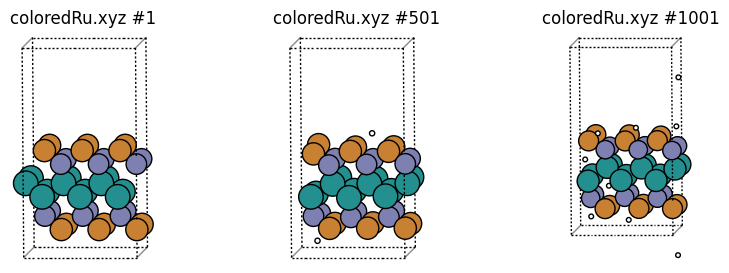

In [16]:
plot_trajectory("coloredRu.xyz");

We can easily see that these groups correspond to surface Ru, subsurface Ru, and "bulk" Ru.

**In "h_cn6.xyz" we print only the frames that contain at least 1 H coordinated to 6 Ru, and print those hydrogen atoms as "Li" for easy visualization**. Note that the frame numbers are not the same as in the original trajectory, since only some of the frames are printed:

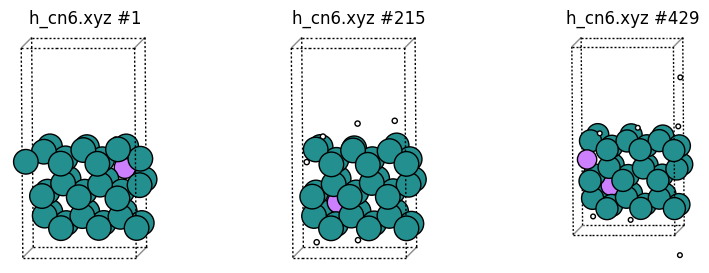

In [17]:
plot_trajectory("h_cn6.xyz");

**SingleEnvironment**: Sometimes, especially for large systems, it can be difficult to see the "interesting" atoms if other atoms obscure it. The ``SingleEnvironment`` alias can be used to print just a sphere around the atom. If there is more than 1 group member in a given frame, then a random group member is chosen.

In "h_cn6_3ang.xyz" we print random hydrogen atoms coordinated to at least 6 Ru, but just the environment within 3 angstrom of the H atom (which again is printed as Li). If the environment is split across the periodic boundary, then the minimum image convention is used.

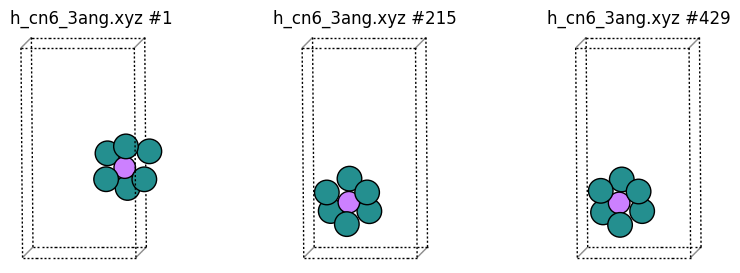

In [18]:
plot_trajectory("h_cn6_3ang.xyz");

**Let's also plot some H2 molecules as Li**:

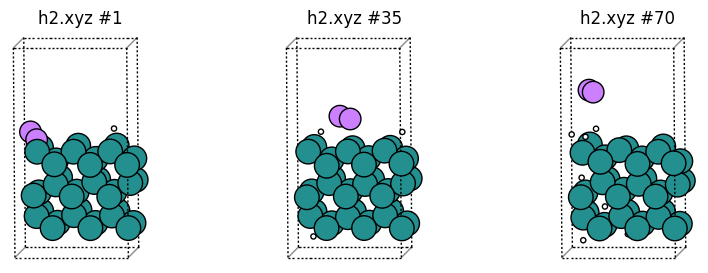

In [19]:
plot_trajectory("h2.xyz");

**In the H-H rdf there was a small peak at ~0.3 angstrom. Let's print the frame(s) where this happened and plot the structures**:

In [20]:
%%sh
cat shorth2.txt

#iter extremelyshorth2 
932 2 


So it's frame 932. Now let's plot:

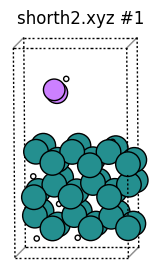

In [21]:
plot_trajectory("shorth2.xyz");

This H2 molecule had such a short bond because in this kind of MD trajectory H atoms are inserted at random above the surface.

Finally, **let's look at averagesize.dat and plot it as a bar diagram**:

In [22]:
df = pd.read_csv("averagesize.dat", sep="\s+", comment="#", names=("Group", "AverageSize"))
df

,Group,AverageSize
0,all,41.172800
1,h,5.172830
2,ru,36.000000
3,ru_ru(allcn),36.000000
4,ru(lowcn),12.007000
5,ru(mediumcn),11.993000
6,ru(highcn),12.000000
7,ru_h(allcn),36.000000
8,h_ru(allcn),5.172830
9,h_ru(cn0),0.747253


This looks reasonable, but there are three groups containing "xxxx" that were not part of the input! These groups were created internally by lionanalysis because of the ``SingleEnvironment`` command. You can see their definitions in the lionanalysis output:

In [23]:
%%sh
grep -i SingleEnvironment lionanalysis_output.txt
grep -i xxxx lionanalysis_output.txt

    ### SingleEnvironment H_Ru(CN6) 3.0 h_cn6_3ang.xyz SPECIAL H_Ru(CN6) Li


DefineGroup h_ru(cn6)XXXXX16 SUBGROUPRANDOM H_Ru(CN6)
DefineGroup h_ru(cn6)XXXXY16 BOND All h_ru(cn6)XXXXX16 MaxDist 3
DefineGroup h_ru(cn6)XXXXZ16 SUM h_ru(cn6)XXXXX16 h_ru(cn6)XXXXY16
PrintGroup h_ru(cn6)XXXXZ16 XYZ h_cn6_3ang.xyz NoEmptyFrames CenterOn 0  SPECIAL H_Ru(CN6) Li


Let's plot the average group size as a bar plot, but exclude the uninteresting "xxxx" groups:

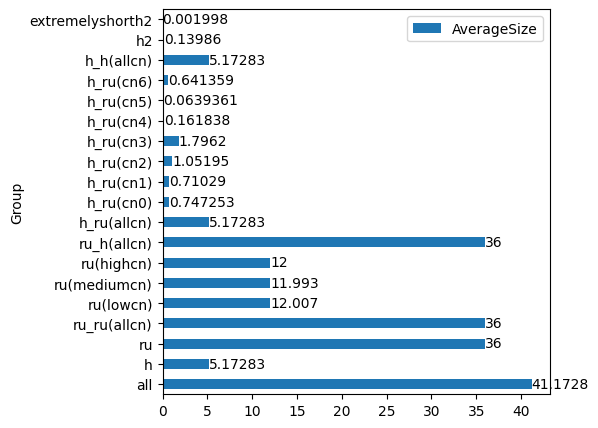

In [24]:
ax = df.drop(
    df[df["Group"].str.contains("xxxx")].index
).plot.barh(x="Group", y="AverageSize", figsize=(5, 5));
ax.bar_label(ax.containers[0]);